<a href="https://colab.research.google.com/github/sayprincekumar20/Fake-News-Prediction/blob/main/Fake_News_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re ,string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words= set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [6]:
!pip install nltk

In [7]:
!pip install kaggle

In [8]:
# we are using Kaggle Api for datasets Fake News Predicton.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
# Api to fetch the dataset from  kaggle
!kaggle datasets download -d rajatkumar30/fake-news

Dataset URL: https://www.kaggle.com/datasets/rajatkumar30/fake-news
License(s): DbCL-1.0
 52% 6.00M/11.5M [00:00<00:00, 59.4MB/s]
100% 11.5M/11.5M [00:00<00:00, 58.0MB/s]


In [10]:
# Extract the  file from zip
import zipfile
with zipfile.ZipFile('/content/fake-news.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [11]:
# loading the data from csv file to pandas dataframe
df = pd.read_csv('/content/news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
df.shape

(6335, 4)

In [13]:
df.rename(columns={'Unnamed: 0' : 'ID'}, inplace= True)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [15]:
df.iloc[:,-3:].describe()

,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


In [16]:
# Check null
df.isnull().sum()

,0
ID,0
title,0
text,0
label,0


In [17]:
# check duplicates
df.duplicated().sum()

0

In [18]:
# check duplicate subset
df[df.duplicated(subset=['text', 'label'])]

,ID,title,text,label
61,1834,Biden makes another surprise political stop,"On this day in 1973, J. Fred Buzhardt, a lawye...",REAL
90,1661,Exclusive: GOP campaigns plot revolt against RNC,"Killing Obama administration rules, dismantlin...",REAL
157,1329,How Clinton plans to stop Sanders' momentum,"Killing Obama administration rules, dismantlin...",REAL
233,1770,"Scott Walker, Rick Perry show limits of super ...","On this day in 1973, J. Fred Buzhardt, a lawye...",REAL
316,1570,Rand Paul is flatlining,"Killing Obama administration rules, dismantlin...",REAL
...,...,...,...,...
6227,8613,ISIS uses an industrial dough kneader to kill ...,Email \nISIS barbarians used an industrial dou...,FAKE
6233,7171,North Korea Threatens ‘Sacred’ Nuclear War Aga...,Email \nNorth Korea’s Foreign Ministry slammed...,FAKE
6250,2001,Activists bristle at Clinton fundraising,A verdict in 2017 could have sweeping conseque...,REAL
6270,1743,Inside Bernie Sanders’ unorthodox debate prep,"Killing Obama administration rules, dismantlin...",REAL


In [19]:
# Drop subset duplicates
df = df.drop_duplicates(subset=['text','title'])

In [20]:
df.shape

(6306, 4)

In [21]:
# check the features of labels
df['label'].value_counts()

,count
label,
REAL,3154
FAKE,3152


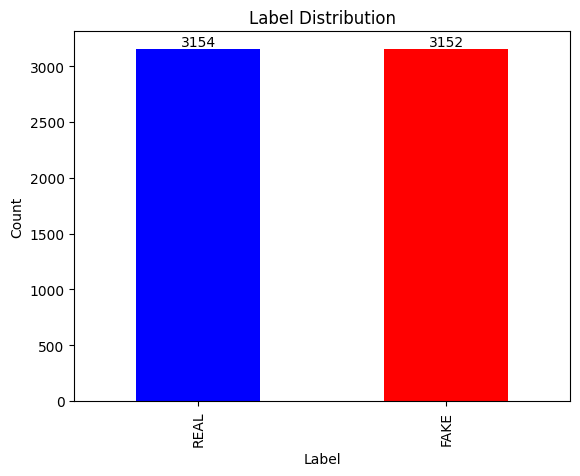

In [22]:
# Visualize the label data
bar = df['label'].value_counts().plot(kind= 'bar', color=['blue','red'])

for i in bar.patches:
  bar.text(i.get_x() + i.get_width()/2, i.get_height() + 0.1, f'{int(i.get_height())}', ha='center',va='bottom')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


Fake and Real news data are balanced, we can use Accuracy metric evaluation as it is balanced

Text(0.5, 1.0, 'Fake Text')

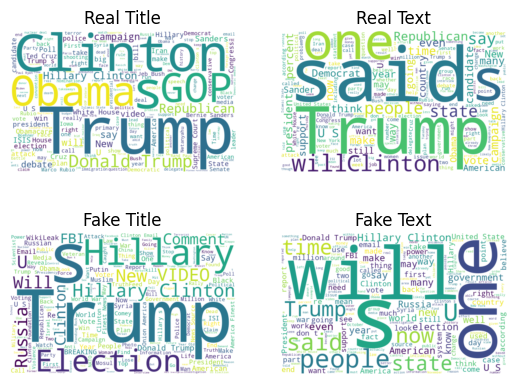

In [23]:
# Worldcloud for Real Title.
real_title= ' '.join(df[df['label']=='REAL']['title'].astype(str))
worldcloud_real_title = WordCloud(width=800, height=500, background_color='white').generate(real_title)

# Worldcloud for Real Text
real_text= ' '.join(df[df['label']=='REAL']['text'].astype(str))
worldcloud_real_text = WordCloud(width=800, height=500, background_color='white').generate(real_text)

# Worldcloud for Fake Title
fake_title= ' '.join(df[df['label']=='FAKE']['title'].astype(str))
worldcloud_fake_title = WordCloud(width=800, height=500, background_color='white').generate(fake_title)

# Worldcloud for Fake Text
fake_text= ' '.join(df[df['label']=='FAKE']['text'].astype(str))
worldcloud_fake_text= WordCloud(width=800, height=500, background_color='white').generate(fake_text)

# Plotting  for Real Title
plt.subplot(2,2,1)
plt.imshow(worldcloud_real_title, interpolation='bilinear')
plt.axis('off')
plt.title('Real Title')

# Plotting for Real Text
plt.subplot(2,2,2)
plt.imshow(worldcloud_real_text, interpolation='bilinear')
plt.axis('off')
plt.title('Real Text')

# Plotting for Fake Title
plt.subplot(2,2,3)
plt.imshow(worldcloud_fake_title, interpolation='bilinear')
plt.axis('off')
plt.title('Fake Title')

#Plotting for Fake Text
plt.subplot(2,2,4)
plt.imshow(worldcloud_fake_text, interpolation='bilinear')
plt.axis('off')
plt.title('Fake Text')



Through word cloud we can seee words which appear often on each fake/real/title/texts.

Real_title_top_10 [('trump', 528), ('clinton', 333), ('obama', 224), ('gop', 222), ('donald', 184), ('hillary', 172), ('debate', 152), ('new', 141), ('2016', 133), ('us', 127)]
real_text_top_10 [('said', 17131), ('trump', 12640), ('clinton', 8734), ('would', 7720), ('one', 6284), ('people', 6121), ('new', 5747), ('us', 5660), ('president', 5655), ('state', 5548)]
fake_title_top_10 [('trump', 399), ('hillary', 350), ('clinton', 282), ('us', 199), ('election', 175), ('new', 139), ('video', 117), ('fbi', 115), ('russia', 114), ('news', 105)]
fake_text_top_10 [('us', 6847), ('trump', 5717), ('clinton', 5631), ('people', 5181), ('one', 4874), ('would', 4872), ('hillary', 4129), ('said', 3957), ('new', 3488), ('like', 3209)]


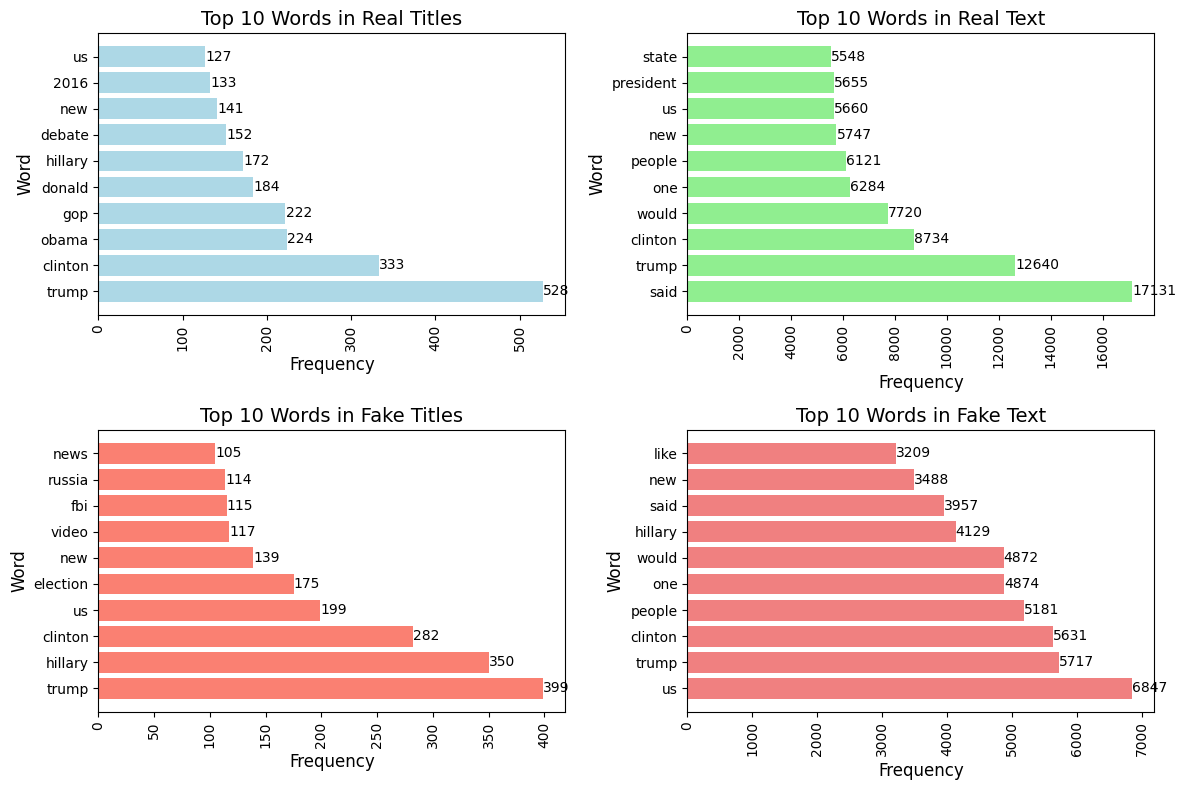

In [24]:
# Top 10 words for every fake/real of text and title
from collections import Counter

# Top 10 Words for Real Title
real_title_count= Counter(word for word in re.sub(r'[^\w\s]', '', real_title.lower()).split() if word not in stop_words)
real_title_top10 = real_title_count.most_common(10)

# Top 10 Words for Real Text
real_text_count= Counter(word for word in re.sub(r'[^\w\s]', '', real_text.lower()).split() if word not in stop_words)
real_text_top10 = real_text_count.most_common(10)

# Top 10 title for Fake Title
fake_title_count= Counter(word for word in re.sub(r'[^\w\s]', '', fake_title.lower()).split() if word not in stop_words)
fake_title_top10 = fake_title_count.most_common(10)

# Top 10 text for Fake Title
fake_text_count= Counter(word for word in re.sub(r'[^\w\s]', '', fake_text.lower()).split() if word not in stop_words)
fake_text_top10 = fake_text_count.most_common(10)

# print
print("Real_title_top_10",real_title_top10)
print("real_text_top_10",real_text_top10)
print("fake_title_top_10",fake_title_top10)
print("fake_text_top_10",fake_text_top10)

# Create the figure and adjust layout
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot Real Title Top 10 Words
plt.subplot(2, 2, 1)
plt.barh([word[0] for word in real_title_top10], [word[1] for word in real_title_top10], color='lightblue')
plt.xticks(rotation=90, fontsize=10)
plt.title('Top 10 Words in Real Titles', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
for i, (word, count) in enumerate(real_title_top10):
    plt.text(count + 0.1, i, str(count), va='center', fontsize=10)

# Plot Real Text Top 10 Words
plt.subplot(2, 2, 2)
plt.barh([word[0] for word in real_text_top10], [word[1] for word in real_text_top10], color='lightgreen')
plt.xticks(rotation=90, fontsize=10)
plt.title('Top 10 Words in Real Text', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
for i, (word, count) in enumerate(real_text_top10):
    plt.text(count + 0.1, i, str(count), va='center', fontsize=10)

# Plot Fake Title Top 10 Words
plt.subplot(2, 2, 3)
plt.barh([word[0] for word in fake_title_top10], [word[1] for word in fake_title_top10], color='salmon')
plt.xticks(rotation=90, fontsize=10)
plt.title('Top 10 Words in Fake Titles', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
for i, (word, count) in enumerate(fake_title_top10):
    plt.text(count + 0.1, i, str(count), va='center', fontsize=10)

# Plot Fake Text Top 10 Words
plt.subplot(2, 2, 4)
plt.barh([word[0] for word in fake_text_top10], [word[1] for word in fake_text_top10], color='lightcoral')
plt.xticks(rotation=90, fontsize=10)
plt.title('Top 10 Words in Fake Text', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
for i, (word, count) in enumerate(fake_text_top10):
    plt.text(count + 0.1, i, str(count), va='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


Some insights are:
1. In Real news have more words collection.
2. Trump and Clinton consistently appear in both fake and real news
3. Fake title tends to have 'sensational' words like FBI, Russia, while Real Title tends to be have more neutral words like debate..

## Text Cleansing

In [25]:
def cleans(text):
  # Remove HTML Tags
  text= re.sub(r'<.*?>', '', text)

  # Remove URLs
  text= re.sub(r'http\S+|www\S+|https\S+', '', text)

  # Remove Emojis
  text= re.sub(r'[^\x00-\x7F]+', '', text)

  # Remove numbers
  text= re.sub(r'\d+', '', text)

  # Remove email address
  text= re.sub(r'\S+@\S+', '', text)

  # Remove Punctuation
  text= re.sub(r'[\u2013\u2026\\-]', '', text)
  text= re.sub('[%s]' % re.escape(string.punctuation),'', text)
  text= text.replace(',',' ').replace("'",' ').replace('"', ' ')

  # Remove extra whitespaces
  text= re.sub(r'\s+', ' ', text)
  return text

df['title_cleaned']= df['title'].apply(cleans)
df['text_cleaned']= df['text'].apply(cleans)

print(df['title_cleaned'][2])
print(df['text_cleaned'][2])


Kerry to go to Paris in gesture of sympathy
US Secretary of State John F Kerry said Monday that he will stop in Paris later this week amid criticism that no top American officials attended Sundays unity march against terrorism Kerry said he expects to arrive in Paris Thursday evening as he heads home after a week abroad He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia Bulgaria He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande then return to Washington The visit by Kerry who has family and childhood ties to the country and speaks fluent French could address some of the criticism that the United States snubbed France in its darkest hour in many years The French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sundays march as about leaders of other nations did Obama was said to have stayed away because his own security needs can be taxing o

## Tokenization

In [26]:
df['title_cleaned']= df['title_cleaned'].str.lower()
df['text_cleaned']= df['text_cleaned'].str.lower()

df['title_tokenized']= df.apply(lambda row: nltk.word_tokenize(row['title_cleaned']), axis=1)
df['text_tokenized']= df.apply(lambda row: nltk.word_tokenize(row['title_cleaned']), axis=1)

print(df['title_tokenized'][2])
print(df['text_tokenized'][2])


['kerry', 'to', 'go', 'to', 'paris', 'in', 'gesture', 'of', 'sympathy']
['kerry', 'to', 'go', 'to', 'paris', 'in', 'gesture', 'of', 'sympathy']


Lemmatization

In [27]:
import spacy
npl= spacy.load('en_core_web_sm')


In [28]:
def lemmatize_text_spacy(text):
  doc= npl(" ".join(text))
  lemmatize_tokens=[token.lemma_ for token in doc]
  return lemmatize_tokens


In [29]:
df['title_lemmatized']= df['title_tokenized'].apply(lemmatize_text_spacy)
df['text_lemmatized']= df['text_tokenized'].apply(lemmatize_text_spacy)

In [30]:
print(df['title_lemmatized'][2])
print(df['text_lemmatized'][2])

['kerry', 'to', 'go', 'to', 'paris', 'in', 'gesture', 'of', 'sympathy']
['kerry', 'to', 'go', 'to', 'paris', 'in', 'gesture', 'of', 'sympathy']


## Stop Words Removal

In [31]:
def remove_stopwords(text):
  stop_words= set(stopwords.words('english'))
  word_tokens= word_tokenize(' '.join(text))
  filtered_text= [word for word in word_tokens if word not in stop_words]
  return filtered_text

In [32]:
df['title_filtered_stopwords']= df['title_lemmatized'].apply(remove_stopwords)
df['text_filtered_stopwords']= df['text_lemmatized'].apply(remove_stopwords)
print(df['title_filtered_stopwords'][2])
print(df['text_filtered_stopwords'][2])

['kerry', 'go', 'paris', 'gesture', 'sympathy']
['kerry', 'go', 'paris', 'gesture', 'sympathy']


In [33]:
df.head(3)

,ID,title,text,label,title_cleaned,text_cleaned,title_tokenized,text_tokenized,title_lemmatized,text_lemmatized,title_filtered_stopwords,text_filtered_stopwords
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,you can smell hillarys fear,daniel greenfield a shillman journalism fellow...,"[you, can, smell, hillarys, fear]","[you, can, smell, hillarys, fear]","[you, can, smell, hillary, fear]","[you, can, smell, hillary, fear]","[smell, hillary, fear]","[smell, hillary, fear]"
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,"[watch, the, exact, moment, paul, ryan, commit...","[watch, the, exact, moment, paul, ryan, commit...","[watch, the, exact, moment, paul, ryan, commit...","[watch, the, exact, moment, paul, ryan, commit...","[watch, exact, moment, paul, ryan, commit, pol...","[watch, exact, moment, paul, ryan, commit, pol..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerry to go to paris in gesture of sympathy,us secretary of state john f kerry said monday...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[kerry, to, go, to, paris, in, gesture, of, sy...","[kerry, to, go, to, paris, in, gesture, of, sy...","[kerry, to, go, to, paris, in, gesture, of, sy...","[kerry, go, paris, gesture, sympathy]","[kerry, go, paris, gesture, sympathy]"


In [34]:
df.tail(3)

,ID,title,text,label,title_cleaned,text_cleaned,title_tokenized,text_tokenized,title_lemmatized,text_lemmatized,title_filtered_stopwords,text_filtered_stopwords
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,antitrump protesters are tools of the oligarch...,antitrump protesters are tools of the oligarc...,"[antitrump, protesters, are, tools, of, the, o...","[antitrump, protesters, are, tools, of, the, o...","[antitrump, protester, be, tool, of, the, olig...","[antitrump, protester, be, tool, of, the, olig...","[antitrump, protester, tool, oligarchy, inform...","[antitrump, protester, tool, oligarchy, inform..."
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,in ethiopia obama seeks progress on peace secu...,addis ababa ethiopia president obama convened ...,"[in, ethiopia, obama, seeks, progress, on, pea...","[in, ethiopia, obama, seeks, progress, on, pea...","[in, ethiopia, obama, seek, progress, on, peac...","[in, ethiopia, obama, seek, progress, on, peac...","[ethiopia, obama, seek, progress, peace, secur...","[ethiopia, obama, seek, progress, peace, secur..."
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL,jeb bush is suddenly attacking trump heres why...,jeb bush is suddenly attacking trump heres why...,"[jeb, bush, is, suddenly, attacking, trump, he...","[jeb, bush, is, suddenly, attacking, trump, he...","[jeb, bush, be, suddenly, attack, trump, here,...","[jeb, bush, be, suddenly, attack, trump, here,...","[jeb, bush, suddenly, attack, trump, matter]","[jeb, bush, suddenly, attack, trump, matter]"


In [35]:
# merge all filtered words of text and title

df['all_words']= df['title_filtered_stopwords'] + df['text_filtered_stopwords']
df['all_words']

,all_words
0,"[smell, hillary, fear, smell, hillary, fear]"
1,"[watch, exact, moment, paul, ryan, commit, pol..."
2,"[kerry, go, paris, gesture, sympathy, kerry, g..."
3,"[bernie, supporter, twitter, erupt, anger, dnc..."
4,"[battle, new, york, primary, matter, battle, n..."
...,...
6330,"[state, department, say, find, email, clinton,..."
6331,"[p, pbs, stand, plutocratic, pentagon, p, pbs,..."
6332,"[antitrump, protester, tool, oligarchy, inform..."
6333,"[ethiopia, obama, seek, progress, peace, secur..."


After all the data is cleaned and processed, now we have a data ready to be processed for further operatons, I choose to combine text and title as for X independent variable.

In [36]:
# import the LabelEncoder class from the sklearn.preprocessing module
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
label_encoder = LabelEncoder()

# use the fit_transform method to encode the 'label' column
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [37]:
print(df['label_encoded'])

0       0
1       0
2       1
3       0
4       1
       ..
6330    1
6331    0
6332    0
6333    1
6334    1
Name: label_encoded, Length: 6306, dtype: int64


## Vectorization

The data we have is still in text format, while our model requires numerical values. Therefore, we need to perform a vectorization process, which converts text into its numerical representation in vector format. There are several vectorization methods available, but I chose to use Word2Vec. Word2Vec is an NLP technique that represents words in a continuous vector space where the context and meaning of words are captured. Since we are dealing with news, capturing the semantic meaning is crucial, which is why I decided to use Word2Vec

In [38]:
corpus= df['all_words'].tolist()

In [39]:
from gensim.models import Word2Vec
model= Word2Vec(corpus, min_count=1, workers=5)

In [40]:

def doc_to_vector(documnet, model):
  word_vectors= [model.wv[word] for word in documnet if word in model.wv]
  if word_vectors: # Changed condition to check if word_vectors is not empty
    return np.mean(word_vectors, axis=0)
  else:
    return np.zeros(model.vector_size)

X= np.array([doc_to_vector(doc, model) for doc in corpus])

In [41]:
X.shape

(6306, 100)

Modeling

In [42]:
y= df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [43]:
classifier= [LogisticRegression(),
             KNeighborsClassifier(),
             SVC(),
             DecisionTreeClassifier(),
             RandomForestClassifier(),
             XGBClassifier(use_label_encoder= False),
             LGBMClassifier(force_col_wise=True)]

for cls in classifier:
  cls.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 2496, number of negative: 2548
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 5044, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494845 -> initscore=-0.020619
[LightGBM] [Info] Start training from score -0.020619


In [44]:
# Dictionary of pipelines and model types for references
pipe_dict = {0: "Logistic Regression", 1: "K-Nearest Neighbors", 2: "Support Vector Machine",
             3: "Decision Tree", 4: "Random Forest", 5: "XGBoost", 6: "LightGBM"}


# Fit and predict
for i, model in enumerate(classifier):
   cv_score = cross_val_score(model, X_train, y_train, scoring= "accuracy" ,cv=10)
   print("{} Test Accuracy: {}".format(pipe_dict[i], cv_score.mean()))

Logistic Regression Test Accuracy: 0.6681137042275657
K-Nearest Neighbors Test Accuracy: 0.6510722143642935
Support Vector Machine Test Accuracy: 0.6161755461260412
Decision Tree Test Accuracy: 0.6332213578500706
Random Forest Test Accuracy: 0.7206510293886531
XGBoost Test Accuracy: 0.7071817538896746
[LightGBM] [Info] Number of positive: 2246, number of negative: 2293
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4539, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494823 -> initscore=-0.020710
[LightGBM] [Info] Start training from score -0.020710
[LightGBM] [Info] Number of positive: 2246, number of negative: 2293
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4539, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494823 -> initscore=-0.020710
[LightGBM] [Info] Start training from score -0.020710
[LightGBM] [Info] Number of positiv

Hyperparameter Tuning

In [ ]:
# Define models
models = [
    ('SVC', SVC()),
     ('XGB',XGBClassifier()),
    ('LGBM',LGBMClassifier())
    ]

# Define hyperparameter distribution
param_dist_svc= {
    'C':np.logspace(-2,1,4),
    'kernel':['linear','rbf'],
    'gamma':['scale','auto']
}

param_dist_xgb= {
    'n_estimators': np.arange(50,100,500),  # Number of boosting rounds
    'learning_rate': np.linspace(0.01, 0.3, 5),   # Step size shrinkage
    'max_depth': np.arange(3, 15),  # Maximum depth of the trees
}

param_dist_lgb ={
    'num_leaves': np.arange(20,150,10),
    'learning_rate': np.linspace(0.01, 0.3, 5),
    'n_estimators': np.arange(50,100,500),
}

In [51]:
results =[]

for name, model in models:
  if 'SVC' in name:
    random_search = RandomizedSearchCV(model, param_distributions=param_dist_svc, n_iter=10, cv=5, scoring='accuracy',random_state=42, n_jobs=-1)
  elif 'XGB' in name:
    random_search = RandomizedSearchCV(model, param_distributions=param_dist_xgb, n_iter= 10, cv=5, scoring='accuracy',random_state= 42, n_jobs=-1)
  else:
    random_search = RandomizedSearchCV(model, param_distributions=param_dist_lgb, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

  random_search.fit(X_test, y_test)
  best_model = random_search.best_estimator_

# K-Fold cross-validation
  kfold = KFold(n_splits=5)
  cv_acc_results = cross_val_score(best_model, X_test, y_test, cv=kfold, scoring='accuracy')
  cv_f1_results = cross_val_score(best_model, X_test, y_test, cv=kfold, scoring='f1')
# Store the results
  results.append({
        'Algorithm': name,
        'Accuracy Mean': round(cv_acc_results.mean() * 100, 2),
        'Accuracy STD': round(cv_acc_results.std() * 100, 2),
        'F1 Mean': round(cv_f1_results.mean() * 100, 2),
        'F1 STD': round(cv_f1_results.std() * 100, 2)
    })

# Convert to DataFrame for easy comparison
model_results = pd.DataFrame(results)
print(model_results)

[LightGBM] [Info] Number of positive: 658, number of negative: 604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 1262, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521395 -> initscore=0.085631
[LightGBM] [Info] Start training from score 0.085631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [52]:
print("Best parameters for SVC:", random_search.best_params_)

Best parameters for SVC: {'num_leaves': 80, 'n_estimators': 50, 'learning_rate': 0.22749999999999998}


Model Evaluation

In [53]:
best_svc= random_search.best_estimator_
best_svc.fit(X_train, y_train)
y_pred= best_svc.predict(X_test)

[LightGBM] [Info] Number of positive: 2496, number of negative: 2548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 5044, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494845 -> initscore=-0.020619
[LightGBM] [Info] Start training from score -0.020619


In [54]:
# Classification Reports
from sklearn.metrics import classification_report

print("Classification Report for Support Vector Classifier:")
print(classification_report(y_test, y_pred))

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       604
           1       0.72      0.66      0.69       658

    accuracy                           0.69      1262
   macro avg       0.69      0.69      0.69      1262
weighted avg       0.69      0.69      0.69      1262



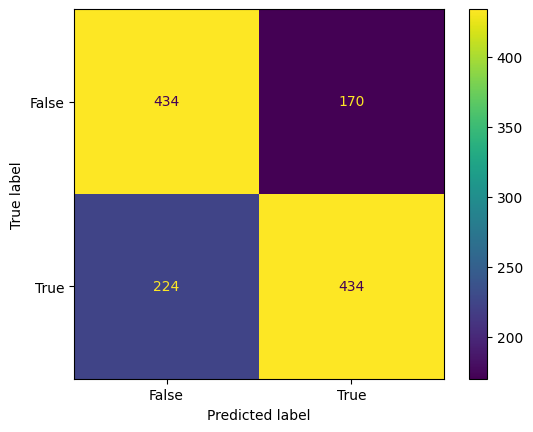

In [55]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()

In [ ]:
Thank You!!